In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.set_printoptions(legacy='1.13')

import warnings
warnings.simplefilter('ignore')

# 1. Preprocressing [6 points]

In [ ]:
import pdfplumber
import csv

# Open your PDF
with pdfplumber.open('killed-in-gaza_moh_2025-03-23.pdf') as pdf:
    with open('killed-in-gaza_moh_2025-03-23.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        
        for page in pdf.pages:
            tables = page.extract_tables()
            for table in tables:
                for row in table:
                    writer.writerow(row)


In [ ]:
import json
import csv

def expand_csv(d, prefix=''):
    expanded = {}
    for k, v in d.items():
        key = f"{prefix}_{k}" if prefix else k
        if isinstance(v, dict):
            expanded.update(expand_csv(v, key)) # Recursively expand nested dictionaries
        else:
            expanded[key] = v
    return expanded

def convert(json_path, csv_path):
    with open(json_path, 'r', encoding='utf-8') as jf:
        data = [expand_csv(entry) for entry in json.load(jf)]

    columns = sorted({key for row in data for key in row})

    with open(csv_path, 'w', newline='', encoding='utf-8') as cf:
        writer = csv.DictWriter(cf, fieldnames=columns)
        writer.writeheader()
        writer.writerows(data)

convert('infrastructure-damaged_2025-04-12.json', 'infrastructure-damaged.csv')


# The cell below is for changing all the nan values in all tables to zero

In [2]:
from datascience import Table
import numpy as np
import math



def check_nulls(table):
    """
    Check for null-like values in all columns of a Table.
    Returns a new Table with columns and whether they contain nulls.
    """
    column_names = table.labels
    columns = []
    has_nulls = []

    for col in column_names:
        values = table.column(col)
        null_found = False

        for val in values:
            if val is None:
                null_found = True
            elif isinstance(val, float) and np.isnan(val):
                null_found = True
            elif isinstance(val, str):
                val_str = val.strip().lower()
                if val_str == '' or val_str == 'nan' or val_str == 'none' or val_str == 'null':
                    null_found = True
            if null_found:
                break

        columns.append(col)
        has_nulls.append("Yes" if null_found else "No")

    return Table().with_columns("Column", columns, "Has Nulls", has_nulls)

def fill_zero(val):
    """Replace nulls (None or NaN) with 0."""
    if val is None:
        return 0
    elif isinstance(val, float) and math.isnan(val):
        return 0
    else:
        return val

def forward_fill(values):
    """Forward-fill a list of values, replacing nulls with previous value."""
    filled = []
    last = 0
    for val in values:
        if val is None or (isinstance(val, float) and math.isnan(val)):
            filled.append(last)
        else:
            filled.append(val)
            last = val
    return filled

# 2. Load CSV Data


infra = Table.read_table('infrastructure-damaged_2025-04-12.csv')
killed25 = Table.read_table('killed-in-gaza_moh_2025-03-23.csv')
wb_daily = Table.read_table('casualties_daily_west_bank_2025-04-12.csv')
killed24 = Table.read_table('killed-in-gaza_2024-09-21.csv').drop('id')
gaza_daily = Table.read_table('casualties_daily_gaza_2025-04-12.csv')


# 3. Check for Nulls in All Tables



print("Null check: Infrastructure damaged")
check_nulls(infra).show()

print("\nNull check: Killed in Gaza 2025")
check_nulls(killed25).show()

print("\nNull check: Casualties Daily - West Bank")
check_nulls(wb_daily).show()

print("\nNull check: Killed in Gaza 2024")
check_nulls(killed24).show()

print("\nNull check: Gaza Daily")
check_nulls(gaza_daily).show()


# 4. Clean Infrastructure Data


for col in infra.labels:
    if col != 'report_date':
        cleaned_col = infra.apply(fill_zero, col)
        infra = infra.with_column(col, cleaned_col)


# 5. Clean West Bank Daily Casualties


# Fill daily counts
for col in ['verified.killed', 'verified.injured', 'verified.killed_children', 'verified.injured_children']:
    filled = wb_daily.apply(fill_zero, col)
    wb_daily = wb_daily.with_column(col, filled)

# Drop old cumulative fields
wb_daily = wb_daily.drop(
    'verified.killed_cum', 'verified.injured_cum',
    'verified.killed_children_cum', 'verified.injured_children_cum',
    'killed_children_cum', 'injured_children_cum'
)

# Recalculate cumulative totals
wb_daily = wb_daily.with_columns(
    'verified.killed_cum', np.cumsum(wb_daily.column('verified.killed')),
    'verified.injured_cum', np.cumsum(wb_daily.column('verified.injured')),
    'verified.killed_children_cum', np.cumsum(wb_daily.column('verified.killed_children')),
    'verified.injured_children_cum', np.cumsum(wb_daily.column('verified.injured_children')),
    'killed_children_cum', np.cumsum(wb_daily.column('verified.killed_children')),
    'injured_children_cum', np.cumsum(wb_daily.column('verified.injured_children'))
)


# 6. Clean Gaza Daily Data


# Fill 'killed' column with 0 and recalculate killed_cum
gaza_daily = gaza_daily.with_column('killed', gaza_daily.apply(fill_zero, 'killed'))
gaza_daily = gaza_daily.drop('killed_cum')
gaza_daily = gaza_daily.with_column('killed_cum', np.cumsum(gaza_daily.column('killed')))

# Forward-fill other cumulative fields if present
for col in ['injured_cum', 'med_killed_cum', 'press_killed_cum']:
    if col in gaza_daily.labels:
        filled = forward_fill(gaza_daily.column(col))
        gaza_daily = gaza_daily.drop(col).with_column(col, filled)


# 7. Final Table Previews


print("\nCleaned Infrastructure Data (first 5 rows):")
infra.show(5)

print("\nCleaned Killed in Gaza 2025 (first 5 rows):")
killed25.show(5)

print("\nCleaned West Bank Casualties (first 5 rows):")
wb_daily.show(5)

print("\nCleaned Killed in Gaza 2024 (first 5 rows):")
killed24.show(5)

print("\nCleaned Gaza Daily (first 5 rows):")
gaza_daily.show(5)


Null check: Infrastructure damaged


Column,Has Nulls
report_date,No
civic_buildings_destroyed,Yes
civic_buildings_ext_destroyed,No
educational_buildings_damaged,Yes
educational_buildings_destroyed,Yes
educational_buildings_ext_damaged,No
educational_buildings_ext_destroyed,No
places_of_worship_churches_destroyed,Yes
places_of_worship_ext_churches_destroyed,No
places_of_worship_ext_mosques_damaged,Yes



Null check: Killed in Gaza 2025


Column,Has Nulls
Index,No
Name,No
Born,No
Age,No
Sex,No
ID number,No



Null check: Casualties Daily - West Bank


Column,Has Nulls
report_date,No
verified.killed,Yes
verified.killed_cum,Yes
verified.injured,Yes
verified.injured_cum,Yes
verified.killed_children,Yes
verified.killed_children_cum,Yes
verified.injured_children,Yes
verified.injured_children_cum,Yes
killed_cum,No



Null check: Killed in Gaza 2024


Column,Has Nulls
name,No
en_name,No
age,No
dob,No
sex,No
source,No



Null check: Gaza Daily


Column,Has Nulls
report_date,No
report_source,No
report_period,No
ext_massacres_cum,No
killed,Yes
killed_cum,Yes
ext_killed,No
ext_killed_cum,No
ext_killed_children_cum,No
ext_killed_women_cum,No



Cleaned Infrastructure Data (first 5 rows):


report_date,civic_buildings_destroyed,civic_buildings_ext_destroyed,educational_buildings_damaged,educational_buildings_destroyed,educational_buildings_ext_damaged,educational_buildings_ext_destroyed,places_of_worship_churches_destroyed,places_of_worship_ext_churches_destroyed,places_of_worship_ext_mosques_damaged,places_of_worship_ext_mosques_destroyed,places_of_worship_mosques_damaged,places_of_worship_mosques_destroyed,residential_destroyed,residential_ext_destroyed
10/7/2023,0,5,0,0,15,1,0,0,4,2,0,0,0,80
10/8/2023,0,11,0,0,30,1,0,0,8,4,0,0,159,159
10/9/2023,0,16,0,0,45,2,0,0,12,6,0,0,790,790
10/10/2023,0,22,0,0,60,2,0,0,17,8,0,0,1009,1009
10/11/2023,27,27,75,3,75,3,0,0,21,10,0,10,2835,2835



Cleaned Killed in Gaza 2025 (first 5 rows):


Index,Name,Born,Age,Sex,ID number
1,Mohammed Hani Mohammed Al-Zahhar,8/9/2023,0,m,444196471
2,Nour Mohammed Aed Udwan,2/27/2023,0,f,444484729
3,Khaled Mumin Amin Shabir,4/16/2023,0,m,444799647
4,Yamen Ibrahim Farid Qaddoura,6/10/2023,0,m,445958408
5,Ahmed Rami Ahmed Abdel Qadir,12/22/2022,0,m,445808546



Cleaned West Bank Casualties (first 5 rows):


report_date,verified.killed,verified.injured,verified.killed_children,verified.injured_children,killed_cum,injured_cum,settler_attacks_cum,flash_source,verified.killed_cum,verified.injured_cum,verified.killed_children_cum,verified.injured_children_cum,killed_children_cum,injured_children_cum
2023-10-07,6,197,2,31,3,23,3,un,6,197,2,31,2,31
2023-10-08,8,127,3,7,13,194,9,un,14,324,5,38,5,38
2023-10-09,4,88,0,19,15,295,19,un,18,412,5,57,5,57
2023-10-10,5,72,0,7,19,332,29,un,23,484,5,64,5,64
2023-10-11,6,85,2,17,26,427,39,un,29,569,7,81,7,81



Cleaned Killed in Gaza 2024 (first 5 rows):


name,en_name,age,dob,sex,source
بنت اسيا نزار محمد ابووردة,Bint Asaia Nazar Muhammad Abu-warda,0,2024-07-18,f,h
ابن ولاء الدوواسة,Abn Wlaa Aldowasah,0,2024-06-16,m,h
أمل محمد جمعة أبو صويص,Amal Muhammad Jmuaah Abu Sois,0,2023-12-05,f,c
ياسر صلاح ياسر الدلو,Yasr Salah Yasr Aldlo,0,2023-10-19,m,h
كارمل علاء وليد حمدان,Karml Alaaa Waleed Hamdan,0,2023-12-11,f,c



Cleaned Gaza Daily (first 5 rows):


report_date,report_source,report_period,ext_massacres_cum,killed,ext_killed,ext_killed_cum,ext_killed_children_cum,ext_killed_women_cum,ext_injured,ext_injured_cum,ext_civdef_killed_cum,ext_med_killed_cum,ext_press_killed_cum,killed_cum,injured_cum,med_killed_cum,press_killed_cum
2023-10-07,mohtel,24,0,232,232,232,0,0,1610,1610,0,6,1,232,1610,6,1
2023-10-08,mohtel,24,0,138,138,370,78,41,178,1788,0,6,1,370,1788,6,1
2023-10-09,mohtel,24,8,190,190,560,91,61,483,2271,0,6,3,560,2271,6,3
2023-10-10,mohtel,24,8,340,340,900,260,230,1729,4000,0,6,7,900,4000,6,7
2023-10-11,gmotel,24,23,200,200,1100,398,230,1184,5184,0,10,7,1100,5184,10,7


# 2. Exploratory Analysis & Visualization [12 points] 

# Plot 1: Analyzing Gaps Between High-Casualty Days in Gaza and the Impact of Ceasefire on Their Frequency

<Figure size 1000x600 with 0 Axes>

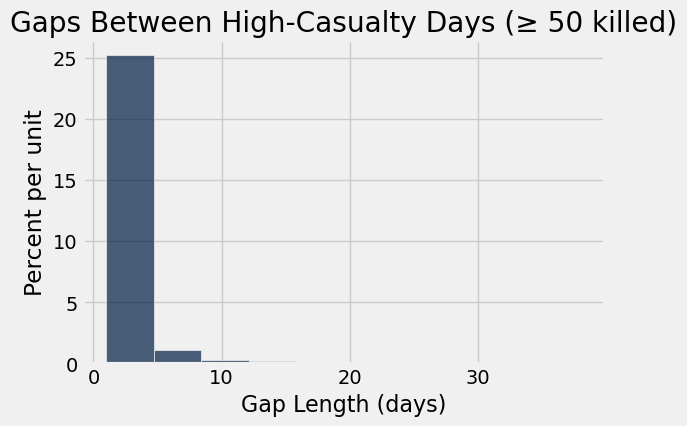

<Figure size 1000x600 with 0 Axes>

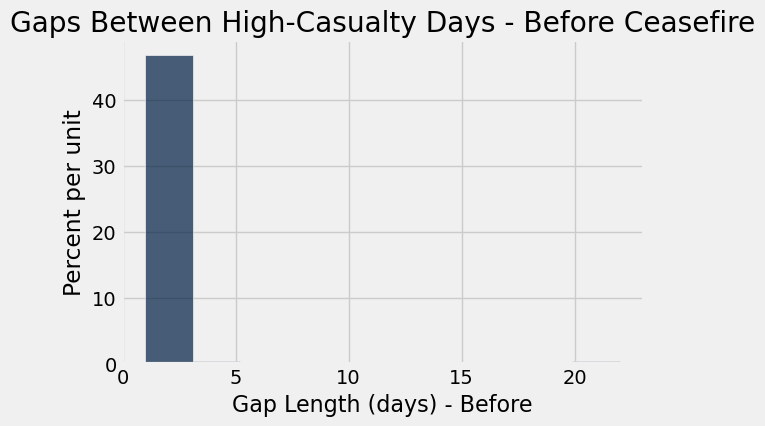

<Figure size 1000x600 with 0 Axes>

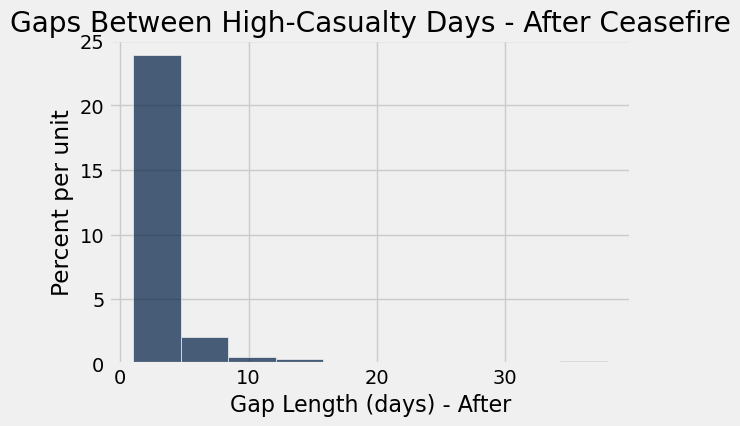

Number of high-casualty days (≥50 killed): 285
Mean high-casualty gap: 1.93 days
Mean high-casualty gap before ceasefire: 1.21 days
Mean high-casualty gap after ceasefire: 2.53 days


In [3]:
# Ensure dates are in chronological order and handle NaN values
gaza_clean = gaza_daily.sort('report_date')
dates = gaza_clean.column('report_date')
casualties = np.array([x if not (isinstance(x, float) and np.isnan(x)) else 0 for x in gaza_clean.column('killed')])

# Create a table with dates and casualties
casualty_data = Table().with_columns('Date', dates, 'Casualties', casualties)

# Function to calculate gaps between events
def calculate_gaps(data, event_condition):
    """Calculate gaps between events defined by the condition function"""
    event_indices = np.where(event_condition(data))[0]
    if len(event_indices) <= 1:
        return np.array([])  # Not enough events to calculate gaps
    
    gaps = np.diff(event_indices)
    return gaps

# Calculate gaps between zero-kill days
zero_kill_condition = lambda data: data == 0
zero_kill_gaps = calculate_gaps(casualties, zero_kill_condition)

# Calculate gaps between high-casualty days (≥ 50 killed)
high_casualty_condition = lambda data: data >= 50
high_casualty_gaps = calculate_gaps(casualties, high_casualty_condition)

# Create a table with the high-casualty gaps
high_gaps_table = Table().with_column('Gap Length (days)', high_casualty_gaps)

# Simple histogram of gaps between high-casualty days
plt.figure(figsize=(10, 6))
high_gaps_table.hist()
plt.title('Gaps Between High-Casualty Days (≥ 50 killed)')
plt.show()

# Split data before and after ceasefire (March 10, 2024)
ceasefire_date = '2024-03-10'
before_indices = casualty_data.where('Date', are.below(ceasefire_date)).column('Casualties')
after_indices = casualty_data.where('Date', are.above_or_equal_to(ceasefire_date)).column('Casualties')

# Calculate high-casualty gaps for both periods
before_high_gaps = calculate_gaps(before_indices, high_casualty_condition)
after_high_gaps = calculate_gaps(after_indices, high_casualty_condition)

# Create tables for before and after gaps
before_gaps_table = Table().with_column('Gap Length (days) - Before', before_high_gaps)
after_gaps_table = Table().with_column('Gap Length (days) - After', after_high_gaps)

# Simple histograms for before and after
plt.figure(figsize=(10, 6))
before_gaps_table.hist()
plt.title('Gaps Between High-Casualty Days - Before Ceasefire')
plt.show()

plt.figure(figsize=(10, 6))
after_gaps_table.hist()
plt.title('Gaps Between High-Casualty Days - After Ceasefire')
plt.show()

# Print simple gap statistics
print(f"Number of high-casualty days (≥50 killed): {np.sum(casualties >= 50)}")

if len(high_casualty_gaps) > 0:
    print(f"Mean high-casualty gap: {np.mean(high_casualty_gaps):.2f} days")

if len(before_high_gaps) > 0:
    print(f"Mean high-casualty gap before ceasefire: {np.mean(before_high_gaps):.2f} days")

if len(after_high_gaps) > 0:
    print(f"Mean high-casualty gap after ceasefire: {np.mean(after_high_gaps):.2f} days")


# Plot 2: Analyzing Gaps Between Zero-Kill Days Before and After Ceasefire in Gaza

<Figure size 1000x600 with 0 Axes>

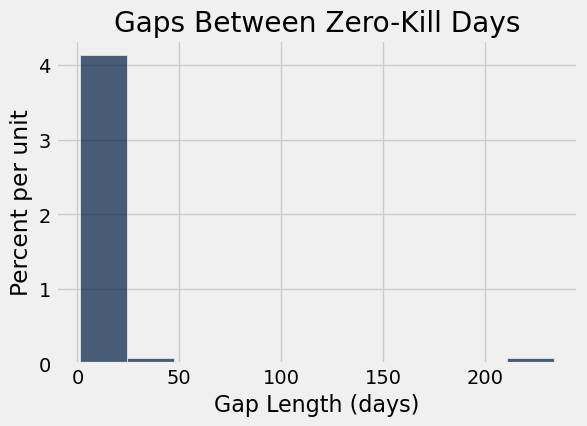

Number of zero-kill days: 56
Mean gap between zero-kill days: 9.02 days
Median gap between zero-kill days: 2.00 days
Maximum gap between zero-kill days: 234 days


<Figure size 1000x600 with 0 Axes>

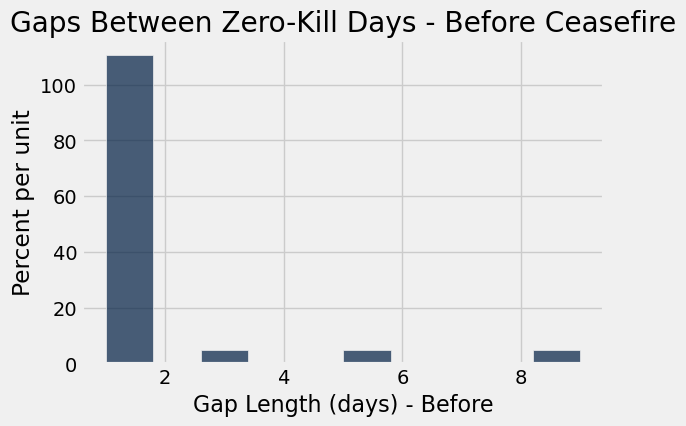

Mean gap between zero-kill days before ceasefire: 1.54 days


<Figure size 1000x600 with 0 Axes>

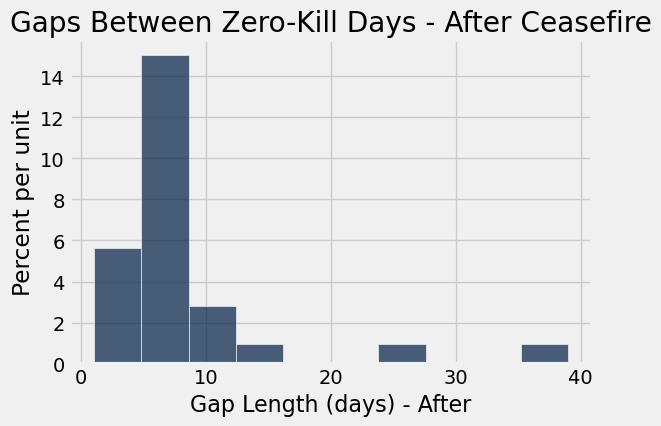

Mean gap between zero-kill days after ceasefire: 7.93 days


In [4]:


# Ensuring dates are in chronological order and handle NaN values
gaza_clean = gaza_daily.sort('report_date')
dates = gaza_clean.column('report_date')
casualties = np.array([x if not (isinstance(x, float) and np.isnan(x)) else 0 for x in gaza_clean.column('killed')])

# Create a table with dates and casualties
casualty_data = Table().with_columns('Date', dates, 'Casualties', casualties)

# Function to calculate gaps between events
def calculate_gaps(data, event_condition):
    """Calculate gaps between events defined by the condition function"""
    event_indices = np.where(event_condition(data))[0]
    if len(event_indices) <= 1:
        return np.array([])  # Not enough events to calculate gaps
    
    gaps = np.diff(event_indices)
    return gaps

# Calculate gaps between zero-kill days
zero_kill_condition = lambda data: data == 0
zero_kill_gaps = calculate_gaps(casualties, zero_kill_condition)

# Create a table with the zero-kill day gaps
zero_gaps_table = Table().with_column('Gap Length (days)', zero_kill_gaps)

# Simple histogram of gaps between zero-kill days
plt.figure(figsize=(10, 6))
zero_gaps_table.hist()
plt.title('Gaps Between Zero-Kill Days')
plt.show()

# Print some basic statistics
print(f"Number of zero-kill days: {np.sum(casualties == 0)}")

if len(zero_kill_gaps) > 0:
    print(f"Mean gap between zero-kill days: {np.mean(zero_kill_gaps):.2f} days")
    print(f"Median gap between zero-kill days: {np.median(zero_kill_gaps):.2f} days")
    print(f"Maximum gap between zero-kill days: {np.max(zero_kill_gaps)} days")

# Split data before and after ceasefire (March 10, 2024)
ceasefire_date = '2024-03-10'
before_indices = casualty_data.where('Date', are.below(ceasefire_date)).column('Casualties')
after_indices = casualty_data.where('Date', are.above_or_equal_to(ceasefire_date)).column('Casualties')

# Calculate zero-kill day gaps for both periods
before_zero_gaps = calculate_gaps(before_indices, zero_kill_condition)
after_zero_gaps = calculate_gaps(after_indices, zero_kill_condition)

# Create tables for before and after gaps
if len(before_zero_gaps) > 0:
    before_zero_table = Table().with_column('Gap Length (days) - Before', before_zero_gaps)
    plt.figure(figsize=(10, 6))
    before_zero_table.hist()
    plt.title('Gaps Between Zero-Kill Days - Before Ceasefire')
    plt.show()
    print(f"Mean gap between zero-kill days before ceasefire: {np.mean(before_zero_gaps):.2f} days")

if len(after_zero_gaps) > 0:
    after_zero_table = Table().with_column('Gap Length (days) - After', after_zero_gaps)
    plt.figure(figsize=(10, 6))
    after_zero_table.hist()
    plt.title('Gaps Between Zero-Kill Days - After Ceasefire')
    plt.show()
    print(f"Mean gap between zero-kill days after ceasefire: {np.mean(after_zero_gaps):.2f} days")



# Plot 3: Monthly Deaths of Medics, Civil Defense, and Press Workers in Gaza (2024)

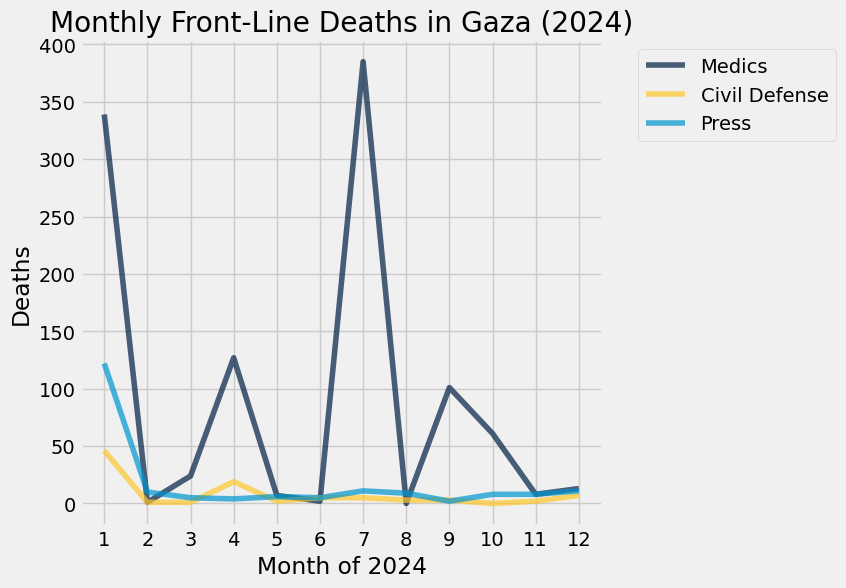

In [5]:
gaza_daily = Table.read_table('casualties_daily_gaza_2025-04-12.csv')
gaza_2024 = gaza_daily.where('report_date', are.containing('2024'))

def month_from_datestr(date_str):
    return int(date_str[5:7])

months = gaza_2024.apply(month_from_datestr, 'report_date')

work = gaza_2024.with_columns('month', months,'med_cum', gaza_2024.column('ext_med_killed_cum'),'civdef_cum', gaza_2024.column('ext_civdef_killed_cum'),
    'press_cum', gaza_2024.column('ext_press_killed_cum'))

month_end = (work.select('month', 'med_cum', 'civdef_cum', 'press_cum')
                  .group('month', np.max)
                  .sort('month'))

monthly_med = np.diff(month_end.column('med_cum max'), prepend=0)
monthly_civdef = np.diff(month_end.column('civdef_cum max'), prepend=0)
monthly_press = np.diff(month_end.column('press_cum max'), prepend=0)

plot_tbl = Table().with_columns('Month', month_end.column('month'),'Medics', monthly_med,'Civil Defense', monthly_civdef,'Press', monthly_press)

plot_tbl.plot('Month')
plt.title('Monthly Front-Line Deaths in Gaza (2024)')
plt.xlabel('Month of 2024')
plt.ylabel('Deaths')
plt.xticks(np.arange(1, 13))
plt.show()


# Plot 4: Frequency of Massacres in Gaza by Day of the Week

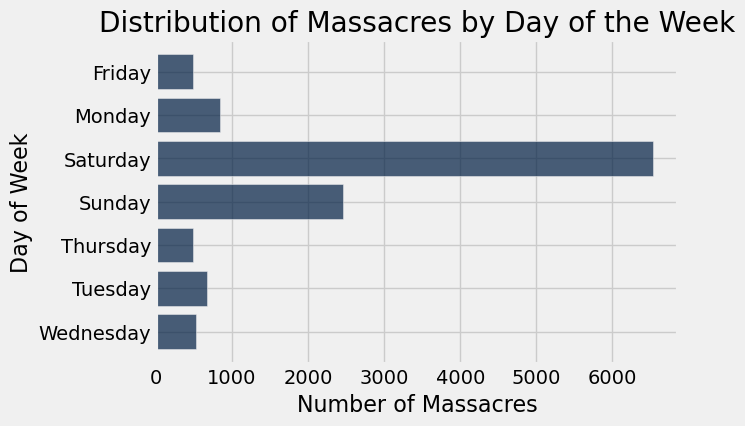

In [6]:
# here basically created a column new column ext_massacres that is not cumulative, shows the exact number of massacres in each day
cum_massacres = gaza_daily.column('ext_massacres_cum')

daily_massacres = np.diff(cum_massacres)

daily_massacres = np.append(0, daily_massacres)

gaza_daily = gaza_daily.with_column('ext_massacres', daily_massacres)


# here i added a new column 'day' to gaza_daily table which shows the day of the week of the report date
import datetime

def get_day(date_string):
    dt = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return dt.strftime('%A')  
    
day_names = gaza_daily.apply(get_day, 'report_date')

gaza_daily = gaza_daily.with_column('day', day_names)




massacres_by_day = gaza_daily.select('day', 'ext_massacres').group('day', sum).sort('day')

massacres_by_day = massacres_by_day.relabeled('ext_massacres sum', 'Massacres')

massacres_by_day.barh('day', 'Massacres')
plt.title('Distribution of Massacres by Day of the Week')
plt.ylabel('Day of Week')
plt.xlabel('Number of Massacres')
plt.show()


# Plot 5: Average Number of Children Killed per Massacre Over Time in Gaza

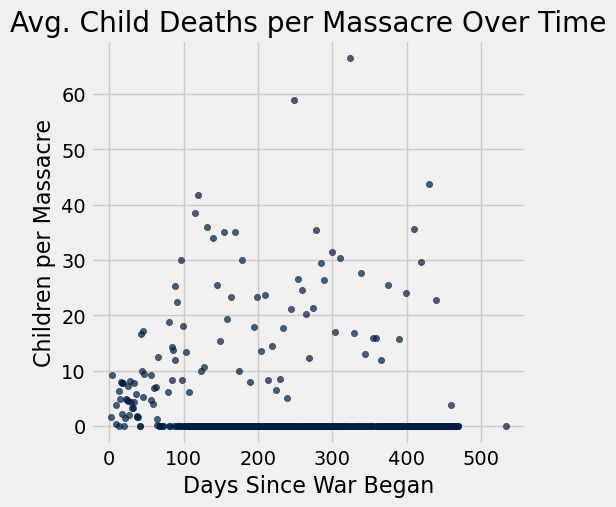

In [7]:
def daily_from_cumulative(column_array):
    return np.diff(column_array, prepend=column_array[0])

massacres_cum = gaza_daily.column('ext_massacres_cum')
children_cum  = gaza_daily.column('ext_killed_children_cum')
dates         = gaza_daily.column('report_date')

massacres_day = daily_from_cumulative(massacres_cum)
children_day  = daily_from_cumulative(children_cum)

from datetime import datetime
start = datetime.strptime(dates[0], "%Y-%m-%d")

days = make_array()
for date_str in dates:
    d = datetime.strptime(date_str, "%Y-%m-%d")
    days = np.append(days, (d - start).days)

day_nums = make_array()
ratios   = make_array()

for i in np.arange(len(massacres_day)):
    if massacres_day[i] > 0:
        day_nums = np.append(day_nums, days[i])
        ratios   = np.append(ratios, children_day[i] / massacres_day[i])

result = Table().with_columns('Days Since Start', day_nums,'Child Deaths per Massacre', ratios)

result.scatter('Days Since Start', 'Child Deaths per Massacre')
plt.title('Avg. Child Deaths per Massacre Over Time')
plt.xlabel('Days Since War Began')
plt.ylabel('Children per Massacre')
plt.grid(True)
plt.show()


# Plot 6: Monthly Breakdown of Buildings Destroyed by Category in Chronological Order

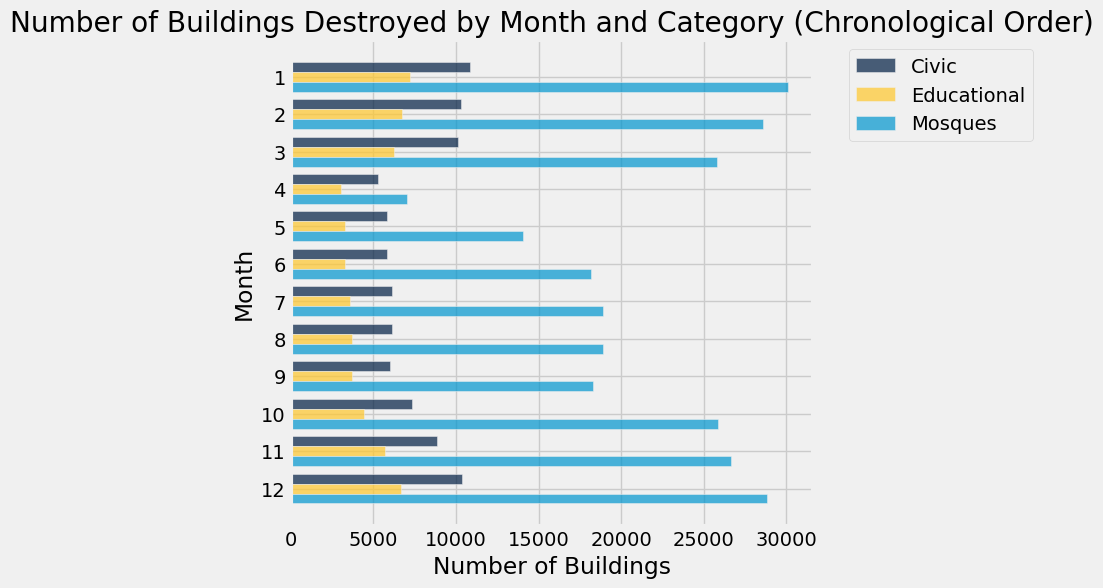

In [16]:
# Extract Month from date
def extract_month(date_str):
    if (date_str[1] == "/"):
        return date_str[:1]
    return date_str[:2]

t = infra.with_column("Month", infra.apply(extract_month, "report_date"))

# Group by Month and sum categories
grouped = t.select(
    "Month", 
    "civic_buildings_ext_destroyed",
    "educational_buildings_ext_destroyed", 
    "places_of_worship_ext_mosques_destroyed"
).group("Month", sum)

grouped = grouped.relabeled("civic_buildings_ext_destroyed sum", "Civic") \
                 .relabeled("educational_buildings_ext_destroyed sum", "Educational") \
                 .relabeled("places_of_worship_ext_mosques_destroyed sum", "Mosques")


# Convert Month to integers for correct chronological order
grouped = grouped.with_column("Month", grouped.apply(int, "Month"))

# Sort chronologically by Month (not by Total)
grouped = grouped.sort("Month")

grouped.drop("Total").barh("Month")
plt.title("Number of Buildings Destroyed by Month and Category (Chronological Order)")
plt.xlabel("Number of Buildings")
plt.show()

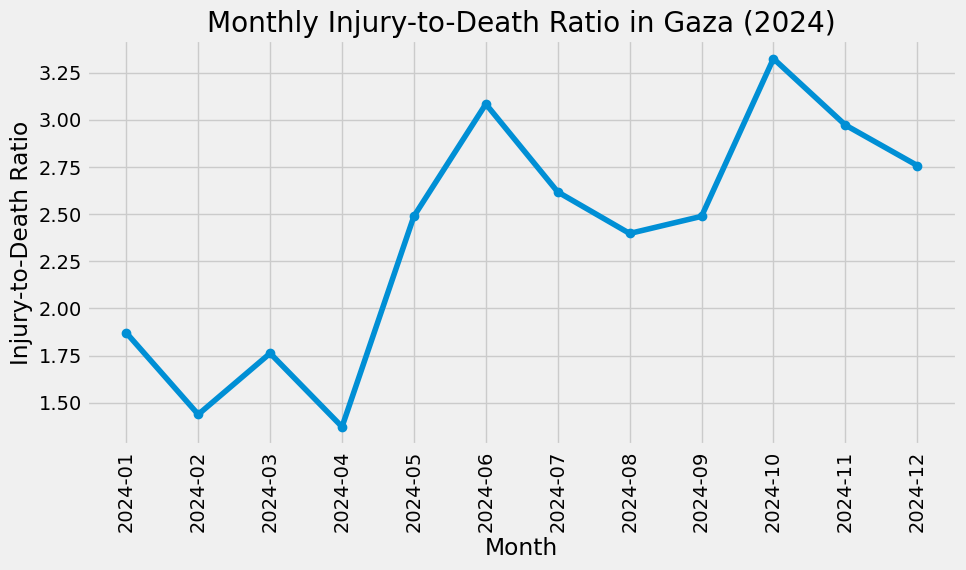

In [9]:
from datetime import datetime


data_2024 = gaza_daily.where('report_date', are.between('2024-01-01', '2024-12-31'))

data_2024 = data_2024.with_column('month', [datetime.strptime(d, '%Y-%m-%d').strftime('%Y-%m') for d in data_2024.column('report_date')])

monthly_data = data_2024.group('month', sum)

monthly_killed = monthly_data.column('ext_killed sum')
monthly_injured = monthly_data.column('ext_injured sum')

injury_to_death_ratio_monthly = monthly_injured / monthly_killed


plt.figure(figsize=(10, 5))
plt.plot(monthly_data.column('month'), injury_to_death_ratio_monthly, marker='o')
plt.ylabel('Injury-to-Death Ratio')
plt.xlabel('Month')
plt.title('Monthly Injury-to-Death Ratio in Gaza (2024)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


The injury-to-death ratio is a useful way to understand how the healthcare system is doing during the conflict. When the ratio is low, it means more injured people are dying, likely because hospitals and medical help are not available or scarse due to the rapid bombardment. A higher ratio means more people are surviving their injuries, showing that the medical system is working or at a stable status. This graph highlights trends of injured to death ratio in 2024 per month. This can show months where medical operations were scarse and shows indications of how the zionist attacks have impacted the healthcare structre during the war. 

# 3. Hypothesis Testing [12 points]

# 1. Hypothesis Test:

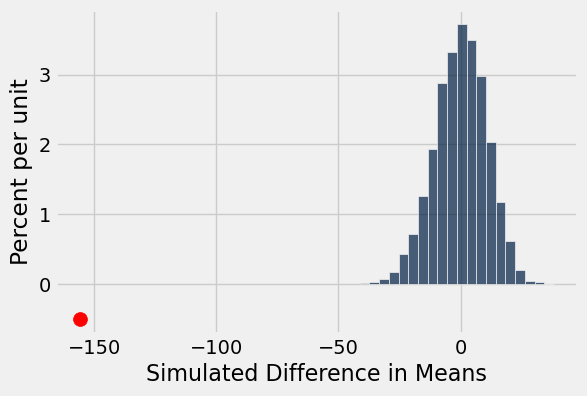

Mean daily casualties before UN ceasefire request: 206.29
Mean daily casualties after UN ceasefire request: 50.22
Observed difference: -156.07
P-value: 0.0000
We reject the null hypothesis. There is significant evidence that casualty patterns changed after the UN ceasefire request.


In [10]:

# We used March 10, 2024 as the intervention date (Ramadan start)
before_data = gaza_daily.where('report_date', are.below('2024-03-10'))
after_data = gaza_daily.where('report_date', are.above_or_equal_to('2024-03-10'))

# Get daily casualties for both periods and filter out NaN values
before_casualties = np.array([x for x in before_data.column('killed') if not (isinstance(x, float) and np.isnan(x))])
after_casualties = np.array([x for x in after_data.column('killed') if not (isinstance(x, float) and np.isnan(x))])

# Calculate daily averages for both periods
before_mean = np.mean(before_casualties)
after_mean = np.mean(after_casualties)

# Calculate the observed test statistic - difference in mean casualties
observed_statistic = after_mean - before_mean

# Combine all casualty data for simulation
all_casualties_table = Table().with_column('Casualties', np.append(before_casualties, after_casualties))
n_before = len(before_casualties)
n_after = len(after_casualties)

# Function to simulate one test statistic
def simulate_one_statistic():
    # Shuffle the casualty data
   
    shuffled_casualties = all_casualties_table.sample(with_replacement=False).column('Casualties')
    
    # Split into two groups of the same size as our original groups
    simulated_before = shuffled_casualties[:n_before]
    simulated_after = shuffled_casualties[n_before:]
    
    # Calculate means for the simulated groups
    sim_before_mean = np.mean(simulated_before)
    sim_after_mean = np.mean(simulated_after)
    
    # Return the difference in means
    return sim_after_mean - sim_before_mean

# Simulate many copies of the test statistic
simulated_statistics = make_array()

repetitions = 10000
for i in np.arange(repetitions):
    simulated_statistics = np.append(simulated_statistics, simulate_one_statistic())

# Calculate the p-value
p_value = np.sum(simulated_statistics <= observed_statistic) / repetitions

# Compare the simulated distribution with the observed statistic
results_table = Table().with_column('Simulated Difference in Means', simulated_statistics)
results_table.hist(bins=20)
plt.scatter(observed_statistic, -0.005, color='red', s=100)
plt.show()
print(f"Mean daily casualties before UN ceasefire request: {before_mean:.2f}")
print(f"Mean daily casualties after UN ceasefire request: {after_mean:.2f}")
print(f"Observed difference: {observed_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("We reject the null hypothesis. There is significant evidence that casualty patterns changed after the UN ceasefire request.")
else:
    print("We fail to reject the null hypothesis. There is not sufficient evidence that casualty patterns changed after the UN ceasefire request.")


# 2. Hypothesis Test: Are Massacres Equally Likely on All Days of the Week?
Null Hypothesis: The probability that a massacre occurs is the same on all days of the week.
(Any differences in the data are just due to random chance.)

Alternative Hypothesis: The probability that a massacre occurs differs between days of the week.
(Some days are more or less likely to have massacres.)


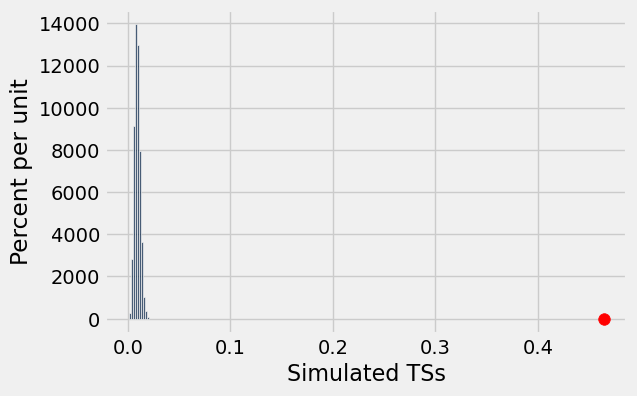

P-value=  0.0


In [15]:
total_massacres = np.sum(gaza_daily.column('ext_massacres'))

massacres_per_day = gaza_daily.select('day', 'ext_massacres').group('day', sum)

observed_distribution = massacres_per_day.column('ext_massacres sum') / total_massacres

massacres_per_day = massacres_per_day.with_column('Proportion of Massacres', observed_distribution)

massacres_per_day



null_distribution = np.ones(7) * (1/7)

def calculate_test_statistic(obs_dist, null_dist):
    return np.sum(abs(obs_dist-null_dist))/2
    
observed_ts = calculate_test_statistic(observed_distribution,null_distribution)
observed_ts



simulated_ts = make_array()
total_num_of_massacres = gaza_daily.sort('ext_massacres_cum',descending=True).column('ext_massacres_cum').item(3)

for i in range(20000):
    simulated_tvds = calculate_test_statistic(sample_proportions(total_num_of_massacres,null_distribution),null_distribution)
    simulated_ts = np.append(simulated_ts,simulated_tvds)
simulated_ts 



Table().with_column("Simulated TSs", simulated_ts).hist()
plt.scatter(observed_ts, -0.1, color='red', s=70, zorder=2);
plt.show();

p_value_ts = sum(simulated_ts >= observed_ts) / 20000
print("P-value= ",p_value_ts)

conclusion: p-value is zero so the null hypothesis is rejected, which means that means the IDF are choosing specific days of the week to commit massacres 

# 3. (Hypothesis Test): Are Frontline Worker Deaths Equally Likely Across Worker Types?
Null Hypothesis: The probability that a frontline worker is killed is the same for medics, civil defense, and press workers.
(Any differences in the data are just due to random chance.)

Alternative Hypothesis: The probability that a frontline worker is killed differs between worker types.
(Some roles are more likely to be targeted by the IDF.)

Test statistic: TVD, large values mean the model is good however, smaller values means that model is bad

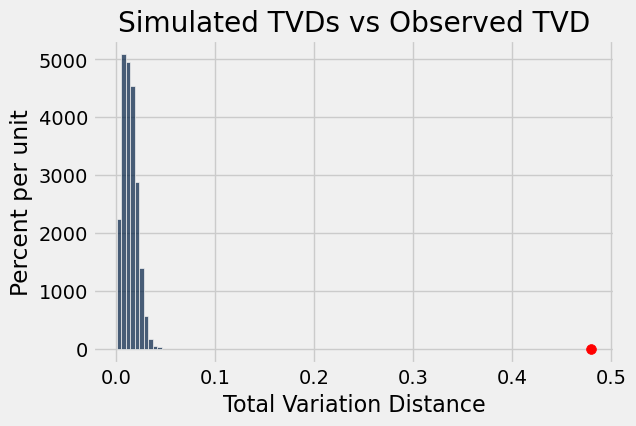

p value= 0.0


In [13]:
total_medics = gaza_daily.column('ext_med_killed_cum').item(gaza_daily.num_rows-1)
total_civdef = gaza_daily.column('ext_civdef_killed_cum').item(gaza_daily.num_rows-1)
total_press = gaza_daily.column('ext_press_killed_cum').item(gaza_daily.num_rows-1)

observed_counts = make_array(total_medics, total_civdef, total_press)
total_deaths = sum(observed_counts)
observed_dist = observed_counts / total_deaths

null_dist = make_array(1/3, 1/3, 1/3)

def calculate_tvd(obs, exp):
    return np.sum(np.abs(obs - exp)) / 2

observed_tvd = calculate_tvd(observed_dist, null_dist)

simulated_tvds = make_array()

for i in range(10000):
    sample = sample_proportions(total_deaths, null_dist)
    sim_tvd = calculate_tvd(sample, null_dist)
    simulated_tvds = np.append(simulated_tvds, sim_tvd)

Table().with_column("Simulated TVDs", simulated_tvds).hist()
plt.scatter(observed_tvd, -0.005, color='red', s=50, zorder=2)
plt.title("Simulated TVDs vs Observed TVD")
plt.xlabel("Total Variation Distance")
plt.show()

p_value = np.count_nonzero(simulated_tvds >= observed_tvd) / 10000
print('p value=',p_value)


conclusion: Reject the null hypothesis, which means that the IDF are targeting a specific front line worker type rather than the other type

# 4. Hypothesis Test: Are More Males Killed Than Females? *** Extra Work ***
Null Hypothesis:
The number of males and females killed is random meaning there is no systematic gender targeting.
(Any difference in the number of male vs. female deaths is just due to chance.)

Alternative Hypothesis:
More males are killed than females, on average, possibly due to systematic targeting or possible roles such as joining Hamas

Test statistic: percentage of male killed - 51% which is the expected percentage of male deaths. Large values means that men and women were not killed randomly however they were systematically targeted

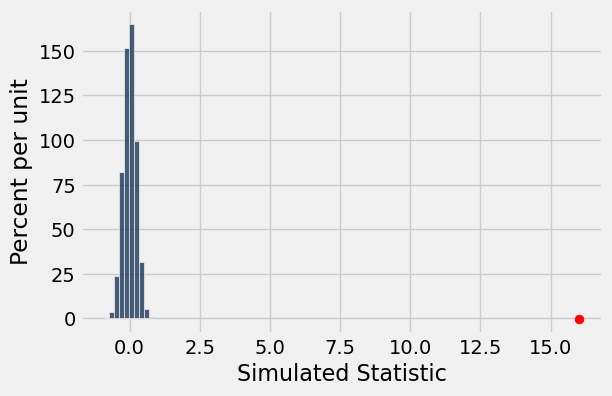

p value:  0.0


In [14]:
population_proportions = make_array(0.51, 0.49)  # percentage of males is 51% and females is 49% (source: https://www.cia.gov/the-world-factbook/countries/gaza-strip/)

total_killed = killed25.num_rows

percentage_of_males_killed = killed25.where('Sex','m').num_rows / total_killed * 100
observed_statistic = percentage_of_males_killed - 51


def one_simulated_test_statistic():
     return sample_proportions(total_killed,[0.51,0.49]).item(0)*100 - 51
     

num_simulations = 20000

simulated_statistics = make_array()
for i in np.arange(num_simulations):
    simulated_statistics = np.append(simulated_statistics,one_simulated_test_statistic())

one_simulated_test_statistic()

Table().with_columns('Simulated Statistic', simulated_statistics).hist()
plt.scatter(observed_statistic, -0.002, color='red', s=40);
plt.show()

p_value = np.sum(simulated_statistics >= observed_statistic) / num_simulations
print("p value: ",p_value)

conclusion: reject the null hypothesis as the p value is less than 0.5, therefore males are deliberately attacked more by IDF

# 5. (A/B Testing): Weekend vs Weekday Casualties *** Extra Work ***
Because of the result of the previous result, we wanted to explore more to see what part of the week do they target more people, so we are doing this null hypothesis testing

Null Hypothesis: In the population, the distributions of the number of people killed per day on weekdays and weekends are the same.
(They are different in the sample just due to chance.)

Alternative: In the population, the average number of people killed per day on weekends is greater than on weekdays

Test statistic: average number of people dead on weekend days - average number of people dead on weekdays. (Large values means that on average IDF is targeting civilians on weekends more)

In [ ]:
killed_day = gaza_daily.select('day','ext_killed')


def part_of_week(day):
    if (day == 'Saturday' or day == 'Sunday'):
        return 'Weekend'
    else:
        return 'Weekday'
killed_day = killed_day.with_column('week part', killed_day.apply(part_of_week, 'day'))
killed_week_part = killed_day.select('week part','ext_killed')


gaza_daily = gaza_daily.with_column('week part', killed_day.apply(part_of_week, 'day'))


group_mean_tbl = killed_week_part.group("week part",np.average)
group_means = group_mean_tbl.column("ext_killed average")    
avg_weekend_vs_weekday = group_means.item(1) > group_means.item(0)

observed_statistic_ab = group_means.item(1) - group_means.item(0)


shuffled_labels = killed_week_part.sample(with_replacement=False).column('week part')
orig_with_shuff_labels = killed_week_part.with_columns('Shuffled Label', shuffled_labels)


def simulate_one_statistic():
    shuffled_labels = killed_week_part.sample(with_replacement=False).column('week part')
    shuffled_tbl = killed_week_part.select('ext_killed').with_columns('Shuffled Label', shuffled_labels)
    group_means = shuffled_tbl.group("Shuffled Label",np.average).column("ext_killed average")
    test_statistic  = group_means.item(1) - group_means.item(0)
    return test_statistic

simulate_one_statistic()

# Note: This part takes some time to run so take that into consideration
repetitions = 10000

simulated_statistics_ab = make_array()
for i in np.arange(repetitions):
    simulated_statistics_ab = np.append(simulated_statistics_ab, simulate_one_statistic())

Table().with_columns('Simulated Statistic', simulated_statistics_ab).hist()
plt.scatter(observed_statistic_ab, -0.0001, color='red', s=70);
plt.show()


p_val = np.sum(simulated_statistics_ab >= observed_statistic_ab) / repetitions
print("p value= ",p_val)

In [ ]:
conclusion: accept null hypothesis because p-value is greater than 0.05 